In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from collections import Counter
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files


# CNN Arquitectures using CIFAR10 data set

## Support functions and definitions

In [2]:
def summary_metrics_tensor_image_data(tensor_image_data, Sample):
    summary_df = pd.DataFrame({'Sample': [Sample],
                         'Size Pixel data': [tensor_image_data.shape],
                        'Min per channel':[np.array(tensor_image_data.view(3, -1).min(dim=1).values)],
                        'Max per channel':[np.array(tensor_image_data.view(3, -1).max(dim=1).values)],
                        'Mean per channel':[np.array(tensor_image_data.view(3, -1).float().mean(dim=1))],
                        'Std per channel':[np.array(tensor_image_data.view(3, -1).float().std(dim=1))],
                        'Missings': [bool(np.array(torch.isnan(tensor_image_data).any()))]
                              })
    return summary_df

In [3]:
def imshow(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [4]:
def plot_random_images(torch_image_data, labels, n_images):
    random.seed(seed)  # Set the seed
    random_numbers = [random.randint(0,torch_image_data.shape[3]) for _ in range(n_images)]
    images = [torch_image_data[:,:,:,i] for i in random_numbers]
    labels = [class_names[int(labels[i])] for i in random_numbers]
    # show images
    imshow(torchvision.utils.make_grid(images))
    print('  '.join(labels))

In [5]:
def count_of_proportions(sample,image_full_data, image_sub_data):
    # Extract labels from train and validation subsets
    labels = [ class_names[image_full_data.targets[i]] for i in image_sub_data.indices]

    # Count label occurrences in each subset
    label_counts = Counter(labels)

    # Calculate the proportion of each label in each subset
    proportions = {label: (count, count / len(labels) * 100) for label, count in label_counts.items()}

    # Sort by class label
    sorted_labels = sorted(proportions.keys())

    # Display the number of cases and proportions
    print(f'{sample} proportions')
    for label in sorted_labels:
        count, proportion = proportions[label]
        print(f"{label}: {count} cases, {proportion:.2f}%")
    print('Total cases: ', len(image_sub_data))
    print('Total labels: ', len(proportions))

In [6]:
def set_seed(seed):
    '''Defines the initial seeds to make results replicable'''
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
def training_test_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, model_id):
    start_time = time.time()

    training_lossess = []
    training_accuracies = []
    validation_lossess = []
    validation_accuracies = []

    for epoch in range(1, n_epochs + 1):

        #Analysis with training sample
        model.train()
        loss_train = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs)

            #Train lossess
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

            #Train accuracy
            _, predicted = torch.max(outputs, dim=1)
            total_train += labels.shape[0]
            correct_train += int((predicted == labels).sum())

        avg_loss_train = loss_train / len(train_loader)
        accuracy_train = correct_train / total_train

        training_lossess.append(avg_loss_train)
        training_accuracies.append(accuracy_train)

        print('Epoch {}, Avg training loss {}'.format(epoch, avg_loss_train))

        model.eval()
        loss_validation = 0.0
        correct_validation = 0
        total_validation = 0

        with torch.no_grad():
            for imgs, labels in test_loader:
                outputs = model(imgs)
                #Validation lossess
                loss = loss_fn(outputs, labels)
                loss_validation += loss.item()

                #Validation accuracies
                _, predicted = torch.max(outputs, dim=1)
                total_validation += labels.shape[0]
                correct_validation += int((predicted == labels).sum())

            avg_loss_validation = loss_validation / len(test_loader)
            accuracy_validation = correct_validation / total_validation

            validation_lossess.append(avg_loss_validation)
            validation_accuracies.append(accuracy_validation)

    model_outputs = pd.DataFrame({'model_id': [model_id],'train_losses': [training_lossess],
                                  'train_accuracies': [training_accuracies],
                                  'validation_losses': [validation_lossess],
                                  'validation_accuracies': [validation_accuracies]})

    plot_Accuracy_validation(training_accuracies, validation_accuracies, model_id)
    torch.save(model.state_dict(), model_id+'.pth')
    current_time = time.time()
    total = current_time - start_time
    print(f'Training and testing Took: {round(total/60,2)} minutes!')
    print(f'Training Accuracy %: {round(training_accuracies[-1]*100,2)}')
    print(f'Validation Accuracy %: {round(validation_accuracies[-1]*100,2)}')

    return model_outputs

In [8]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy% {}: {:.2f}".format(name , (correct / total)*100))

In [9]:
def validate_test_sample(model, test_loader):
    name, loader = "Test", test_loader
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Accuracy% {}: {:.2f}".format(name , (correct / total)*100))

In [10]:
def load_and_test_model(model_id, loaded_model, test_loader):
    loaded_model.load_state_dict(torch.load(model_id+'.pth', weights_only=True))
    loaded_model.eval()
    validate_test_sample(loaded_model, test_loader)

In [11]:
def plot_Accuracy_validation(training_accuracies, validation_accuracies, model_id):
    epoch_list = list(range(1,len(training_accuracies)+1))
    plt.plot(epoch_list, training_accuracies, label = 'Train Accuracies', marker='o', linewidth=2, color = 'mediumblue')
    plt.plot(epoch_list, validation_accuracies, label = 'Validation Accuracies',  marker='o', linewidth=2, color = 'lightseagreen')
    plt.xlabel('Epochs')
    plt.ylabel('Classification Accuracy')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.xticks(epoch_list)
    plt.title(model_id)
    plt.savefig(f"accuracy_{model_id}.png",dpi=200)
    plt.show()

In [12]:
class_names= ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
#Seed
seed = 0

## Data exploration

### Download data

In [14]:
#Download data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and save in data directory
torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
print('Data loaded succecssfully')

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data loaded succecssfully


### Load raw data

In [15]:
#Load raw image PIL data and transform it to tensor
transform = transforms.Compose([transforms.PILToTensor()])
tensor_cifar10_raw = torchvision.datasets.CIFAR10(root='./data', train=True, transform = transform)
tensor_cifar10_test_raw = torchvision.datasets.CIFAR10(root='./data', train=False, transform = transform)

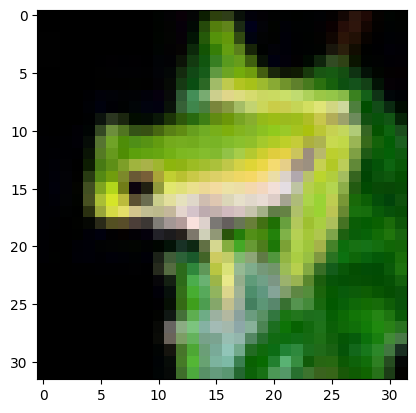

In [16]:
#Example of image in sample
img_t, _ = tensor_cifar10_raw[104]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [17]:
#Stack data into single tensor dataset
full_tensor_data = torch.stack([img_t for img_t, _ in tensor_cifar10_raw], dim=3)
full_tensor_labels = torch.Tensor([label for _ , label in tensor_cifar10_raw])
full_tensor_data_test = torch.stack([img_t for img_t, _ in tensor_cifar10_test_raw], dim=3)
full_tensor_labels_test = torch.Tensor([label for _ , label in tensor_cifar10_test_raw])

### Initial data measurements

#### Batch data

In [18]:
#Summary metrics for image Pixels data: 3 Channels, 50,000 images, 32x32 pixels in the range 0, 255, no missings
summary_metrics_tensor_image_data(full_tensor_data ,'Batch')

,Sample,Size Pixel data,Min per channel,Max per channel,Mean per channel,Std per channel,Missings
0,Batch,"(3, 32, 32, 50000)","[0, 0, 0]","[255, 255, 255]","[125.30691, 122.95039, 113.86539]","[62.99322, 62.088707, 66.7049]",False


In [19]:
#Summary for labels data
print('Labels size:',len(full_tensor_labels) )
print('Proportion for labels in data:')
pd.Series([class_names[int(x)] for x in full_tensor_labels]).value_counts().sort_index()/len(full_tensor_labels)
#50000 labels, 10% equally distribuited categories

Labels size: 50000
Proportion for labels in data:


,count
bird,0.1
car,0.1
cat,0.1
deer,0.1
dog,0.1
frog,0.1
horse,0.1
plane,0.1
ship,0.1
truck,0.1


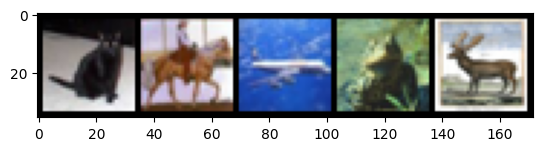

cat  horse  plane  frog  deer


In [20]:
#Sample random images in batch dataset
plot_random_images(full_tensor_data, full_tensor_labels, 5)

#### Test data

In [21]:
#Summary metrics for test image Pixels data: 3 Channels, 10,000 images, 32x32 pixels in the range 0, 255, no missings
summary_metrics_tensor_image_data(full_tensor_data_test ,'Test')

,Sample,Size Pixel data,Min per channel,Max per channel,Mean per channel,Std per channel,Missings
0,Test,"(3, 32, 32, 10000)","[0, 0, 0]","[255, 255, 255]","[126.02465, 123.70853, 114.85431]","[62.896393, 61.93753, 66.70606]",False


In [22]:
#Summary for labels test data
print('Labels size:',len(full_tensor_labels_test) )
print('Proportion for labels in data:')
pd.Series([class_names[int(x)] for x in full_tensor_labels_test]).value_counts().sort_index()/len(full_tensor_labels_test)
#10000 labels, 10% equally distribuited categories

Labels size: 10000
Proportion for labels in data:


,count
bird,0.1
car,0.1
cat,0.1
deer,0.1
dog,0.1
frog,0.1
horse,0.1
plane,0.1
ship,0.1
truck,0.1


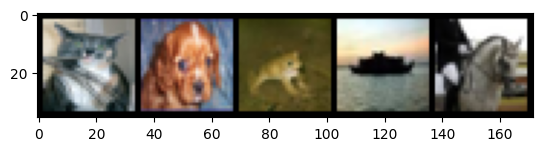

cat  dog  frog  ship  horse


In [23]:
plot_random_images(full_tensor_data_test, full_tensor_labels_test, 5)

#### Data exploration conclusions

##### Data seems already cleaned and proccessed

Since data is clean, we can then transform pixels values into values from 0 to 1 and find the median and std to standardize data, in order to improve performance and convergence for NN

In [24]:
#Summary metrics for data transformed into range [0,1]
summary_metrics_tensor_image_data(full_tensor_data/255 ,'Batch')

,Sample,Size Pixel data,Min per channel,Max per channel,Mean per channel,Std per channel,Missings
0,Batch,"(3, 32, 32, 50000)","[0.0, 0.0, 0.0]","[1.0, 1.0, 1.0]","[0.49139965, 0.48215845, 0.44653094]","[0.24703224, 0.24348514, 0.26158786]",False


Therefore, these values for the mean and std can be used to standardise the pixels in each channel in order to improve performance and convergence at the time of training the NN

In [25]:
mean_values_by_channel = (0.49139965, 0.48215845, 0.44653094)
std_values_by_channel = (0.24703224, 0.24348514, 0.26158786)

## Data Processing

The previous values can be used to standardize data. For this, the functions from pytorch dataset loader will be used to perform the treatment directly at the time of loading the data in order to spare computational resources and run the code from this part for modelling, without needing to run the previous data exploration part.

### Load and transform data

In [26]:
# Define values to standardize Pixels
mean_values_by_channel = (0.49139965, 0.48215845, 0.44653094)
std_values_by_channel = (0.24703224, 0.24348514, 0.26158786)

#Load image data, tranform to tensors into range 0,1 and normal standardise using previous values
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean_values_by_channel, std_values_by_channel)])

cifar10_batch = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
cifar10_batch_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

#Data shape
print('Size Batch data: ',cifar10_batch.data.shape)
print('Size Test data: ', cifar10_batch_test.data.shape)

Size Batch data:  (50000, 32, 32, 3)
Size Test data:  (10000, 32, 32, 3)


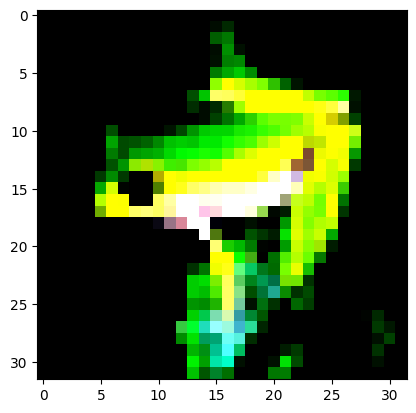

In [27]:
#Sample image in transformed batch sample
img_t, _ = cifar10_batch[104]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

####

#### Split in Train and validation sample

In [28]:
# Extract labels to be splitted
labels = cifar10_batch.targets

# Define the stratified split
train_size = 0.8  #80% for training, 20% for validation
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_size, random_state=seed)

# Get the train and validation index
for train_idx, val_idx in strat_split.split(np.zeros(len(labels)), labels):
    train_subset = Subset(cifar10_batch, train_idx)
    val_subset = Subset(cifar10_batch, val_idx)

count_of_proportions('Train Sample', cifar10_batch, train_subset)
print()
count_of_proportions('Validation Sample', cifar10_batch, val_subset)

Train Sample proportions
bird: 4000 cases, 10.00%
car: 4000 cases, 10.00%
cat: 4000 cases, 10.00%
deer: 4000 cases, 10.00%
dog: 4000 cases, 10.00%
frog: 4000 cases, 10.00%
horse: 4000 cases, 10.00%
plane: 4000 cases, 10.00%
ship: 4000 cases, 10.00%
truck: 4000 cases, 10.00%
Total cases:  40000
Total labels:  10

Validation Sample proportions
bird: 1000 cases, 10.00%
car: 1000 cases, 10.00%
cat: 1000 cases, 10.00%
deer: 1000 cases, 10.00%
dog: 1000 cases, 10.00%
frog: 1000 cases, 10.00%
horse: 1000 cases, 10.00%
plane: 1000 cases, 10.00%
ship: 1000 cases, 10.00%
truck: 1000 cases, 10.00%
Total cases:  10000
Total labels:  10


#### Data loader to use for modelling

In [29]:
batch_size_train = 32
batch_size_val = len(val_subset)
batch_size_test = len(cifar10_batch_test)

In [30]:
# Create DataLoaders for all samples train, validation and test
train_loader = torch.utils.data.DataLoader(train_subset, batch_size= batch_size_train, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size= batch_size_val, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(cifar10_batch_test, batch_size= batch_size_test, shuffle=True, num_workers=2)

## Modelling stage

### Initial review

In [31]:
lr = 0.01
momentum = 0.9
n_epochs = 10
model_results = pd.DataFrame()

#Loss function
criterion = nn.CrossEntropyLoss()

#### Baseline FC Layer

In [32]:
# Define model
class Base_FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) #Apply ReLu and Max pooling
        x = F.relu(self.fc2(x)) #Apply ReLu and Max pooling
        x = self.fc3(x)
        return x

Epoch 1, Avg training loss 1.7238212636947632
Epoch 2, Avg training loss 1.5658129998207093
Epoch 3, Avg training loss 1.4965533537387847
Epoch 4, Avg training loss 1.454123086309433
Epoch 5, Avg training loss 1.4101702635288238
Epoch 6, Avg training loss 1.374158769273758
Epoch 7, Avg training loss 1.3474013820171356
Epoch 8, Avg training loss 1.3175781819820405
Epoch 9, Avg training loss 1.2994601773262024
Epoch 10, Avg training loss 1.2718049346446991


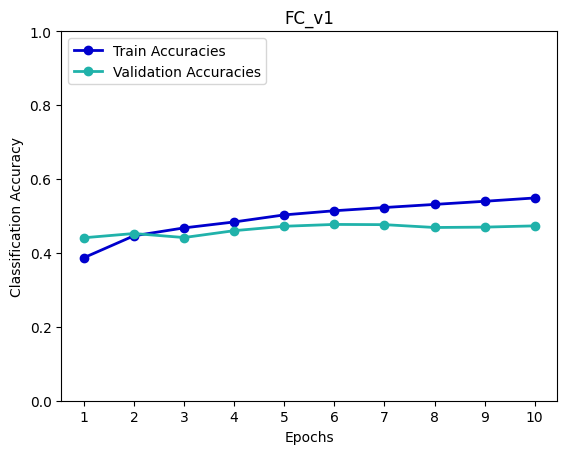

Training and testing Took: 1.8 minutes!
Training Accuracy %: 54.86
Validation Accuracy %: 47.31


In [33]:
# Initialise model instance
set_seed(seed)
model = Base_FC()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Training and evaluating model
model_id = 'FC_v1'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### Baseline CNN Architecture

* 2Conv layers,6 kernels 3x3 after each convolution, activation ReLu and max pooling 2x2. 3FC Layers, stride 1, padding 0

In [34]:
# Define model
class Base_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5) #6 of 32-5+1=28
        self.conv2 = nn.Conv2d(6, 16, 5) #6 of 14-5+1 = 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #5*5*6
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Apply convolution, ReLu and Max pooling
        x = self.pool(F.relu(self.conv2(x))) #Apply convolution, ReLu and Max pooling
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1, Avg training loss 1.7231624776363372
Epoch 2, Avg training loss 1.401662365579605
Epoch 3, Avg training loss 1.2835971358299256
Epoch 4, Avg training loss 1.2078032848358153
Epoch 5, Avg training loss 1.1460548815250398
Epoch 6, Avg training loss 1.0886321393489837
Epoch 7, Avg training loss 1.056630057120323
Epoch 8, Avg training loss 1.016657248234749
Epoch 9, Avg training loss 0.9929014506578445
Epoch 10, Avg training loss 0.9536627974271774


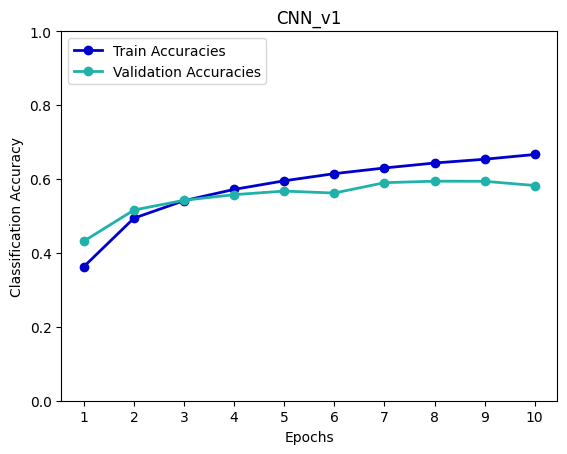

Training and testing Took: 2.03 minutes!
Training Accuracy %: 66.62
Validation Accuracy %: 58.23


In [35]:
# Initialise model instance
set_seed(seed)
model = Base_CNN()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Training model
model_id = 'CNN_v1'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### AlexNet Architecture

This is a lighter version of the original AlexNet, which was designed for larger pixel images (up to 224x224 pixels). Since CIFAR10 is 32x32 images, the kernel size for all convolutions was reduced to 3x3, padding of 1, stride of 1 (except first layer), max pooling of 2x2. Original version https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html

In [36]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, padding = 1), #Kernels of size 3x3, padding 1, stride 1
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace = True))

        self.classifier = nn.Sequential(
            nn.Dropout(), #default .5
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(), #default .5
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

Epoch 1, Avg training loss 1.9432207547187805
Epoch 2, Avg training loss 1.396913280248642
Epoch 3, Avg training loss 1.1231714121341705
Epoch 4, Avg training loss 0.9364257696390152
Epoch 5, Avg training loss 0.7976774371147156
Epoch 6, Avg training loss 0.6710923485994339
Epoch 7, Avg training loss 0.5560073664546012
Epoch 8, Avg training loss 0.46620453891158103
Epoch 9, Avg training loss 0.39754709824323653
Epoch 10, Avg training loss 0.32841469140648843


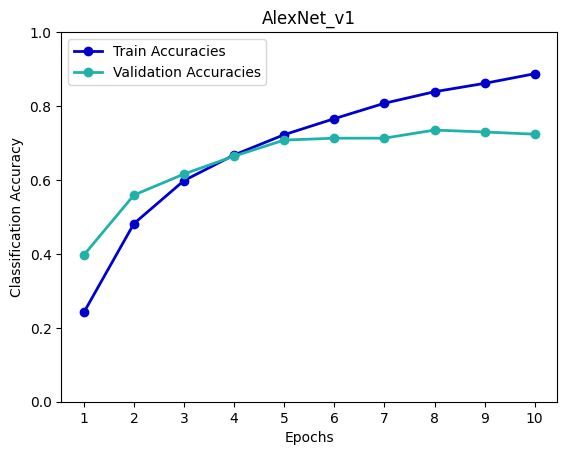

Training and testing Took: 9.81 minutes!
Training Accuracy %: 88.74
Validation Accuracy %: 72.38


In [37]:
# Initialise model instance
set_seed(seed)
model = AlexNet()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Training model
model_id = 'AlexNet_v1'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### GoogleNet Architecture

Adapted version 
Original version https://pytorch.org/hub/pytorch_vision_googlenet/

In [38]:
# Define the GoogleNet model
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        # 1x1 convolution branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Epoch 1, Avg training loss 2.304213608932495
Epoch 2, Avg training loss 2.303803833770752
Epoch 3, Avg training loss 2.3037919260025026
Epoch 4, Avg training loss 2.304070599365234
Epoch 5, Avg training loss 2.3037684225082398
Epoch 6, Avg training loss 2.303876531982422
Epoch 7, Avg training loss 2.303771068191528
Epoch 8, Avg training loss 2.1220758635520935
Epoch 9, Avg training loss 1.896938833618164
Epoch 10, Avg training loss 1.7119112133979797


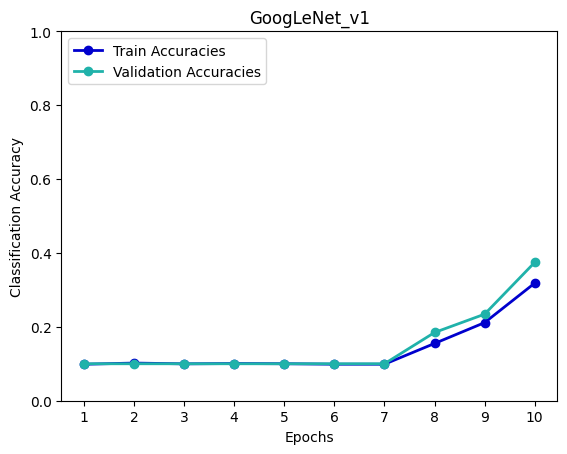

Training and testing Took: 22.62 minutes!
Training Accuracy %: 31.82
Validation Accuracy %: 37.44


In [39]:
# Initialise model instance
set_seed(seed)
model = GoogleNet()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Training model
model_id = 'GoogLeNet_v1'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### Resnet18 Architecture

Adapted version from Resnet18 maintaining numbers of layers and residual connections  https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html

In [40]:
# Define the Resnet18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution layer modified for CIFAR-10 input size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

Epoch 1, Avg training loss 1.4800064631462098
Epoch 2, Avg training loss 0.9104909583091736
Epoch 3, Avg training loss 0.6673472557544708
Epoch 4, Avg training loss 0.5190337279617786
Epoch 5, Avg training loss 0.3939468126505613
Epoch 6, Avg training loss 0.2952377022475004
Epoch 7, Avg training loss 0.21176884752959013
Epoch 8, Avg training loss 0.1605736968383193
Epoch 9, Avg training loss 0.11143056223019958
Epoch 10, Avg training loss 0.08175530841443687


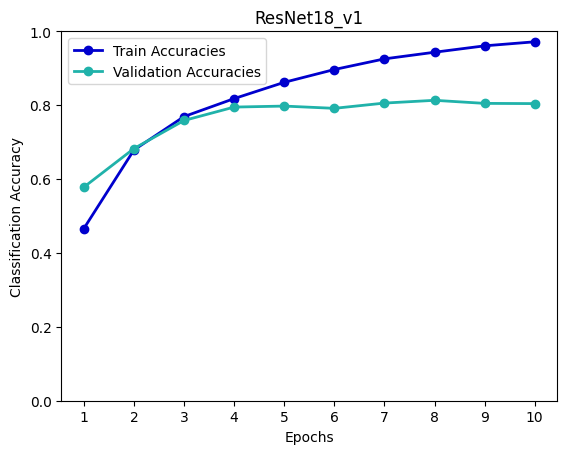

Training and testing Took: 27.53 minutes!
Training Accuracy %: 97.11
Validation Accuracy %: 80.39


In [41]:
# Initialise model instance
set_seed(seed)
model = ResNet18()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Training model
model_id = 'ResNet18_v1'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

### Second review with different optimiser and learning rate 0.001

In [42]:
lr = 0.001

#### Base Convolutional Layer

Epoch 1, Avg training loss 1.609606405878067
Epoch 2, Avg training loss 1.3244884302139281
Epoch 3, Avg training loss 1.2064319244861603
Epoch 4, Avg training loss 1.1188451751708985
Epoch 5, Avg training loss 1.0524272640228272
Epoch 6, Avg training loss 1.0009315612792968
Epoch 7, Avg training loss 0.9532705490112304
Epoch 8, Avg training loss 0.9141521858215332
Epoch 9, Avg training loss 0.880574406003952
Epoch 10, Avg training loss 0.8419013346433639


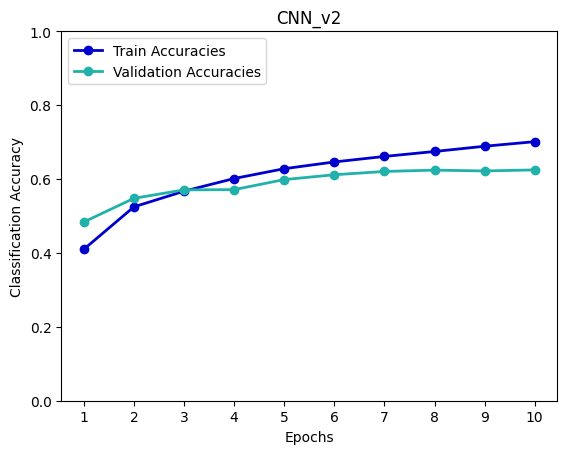

Training and testing Took: 2.27 minutes!
Training Accuracy %: 70.09
Validation Accuracy %: 62.45


In [43]:
# Initialise model instance
set_seed(seed)
model = Base_CNN()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'CNN_v2'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### AlexNet

Epoch 1, Avg training loss 1.7825502626419067
Epoch 2, Avg training loss 1.4130271485805512
Epoch 3, Avg training loss 1.266316769838333
Epoch 4, Avg training loss 1.168156970500946
Epoch 5, Avg training loss 1.1002953675746918
Epoch 6, Avg training loss 1.042804944705963
Epoch 7, Avg training loss 0.9857427580118179
Epoch 8, Avg training loss 0.9352259358882904
Epoch 9, Avg training loss 0.8844181868314743
Epoch 10, Avg training loss 0.8445295282840729


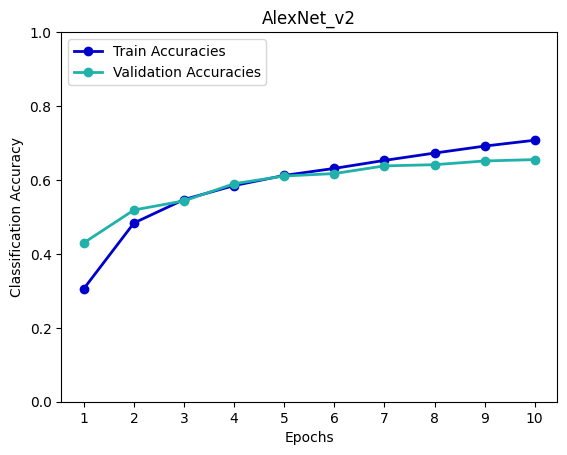

Training and testing Took: 17.29 minutes!
Training Accuracy %: 70.75
Validation Accuracy %: 65.51


In [44]:
# Initialise model instance
set_seed(seed)
model = AlexNet()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'AlexNet_v2'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### GoogLeNet

Epoch 1, Avg training loss 1.9907136178016662
Epoch 2, Avg training loss 6893.984285910607
Epoch 3, Avg training loss 607.2993255353928
Epoch 4, Avg training loss 5.302692054367065
Epoch 5, Avg training loss 4.412989973640442
Epoch 6, Avg training loss 4.159239012718201
Epoch 7, Avg training loss 4.35864149055481
Epoch 8, Avg training loss 6.254435165214539
Epoch 9, Avg training loss 2.425246810722351
Epoch 10, Avg training loss 256873.73564940624


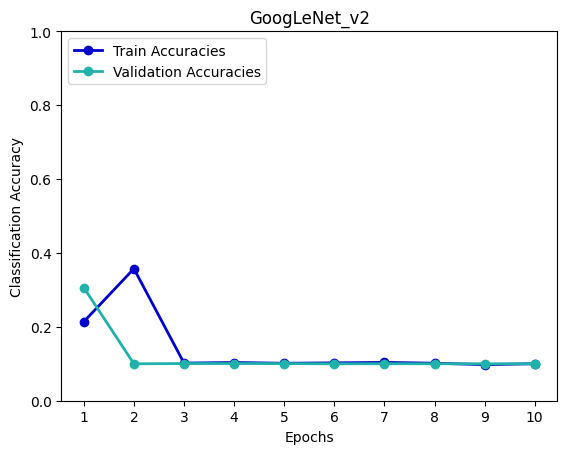

Training and testing Took: 26.37 minutes!
Training Accuracy %: 10.01
Validation Accuracy %: 10.0


In [45]:
# Initialise model instance
set_seed(seed)
model = GoogleNet()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'GoogLeNet_v2'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

#### ResNet18

Epoch 1, Avg training loss 1.4038643793582917
Epoch 2, Avg training loss 0.897692983675003
Epoch 3, Avg training loss 0.6821095460176468
Epoch 4, Avg training loss 0.5416245102286339
Epoch 5, Avg training loss 0.4162929699003696
Epoch 6, Avg training loss 0.31489146159887316
Epoch 7, Avg training loss 0.22350280338972808
Epoch 8, Avg training loss 0.16678865421563388
Epoch 9, Avg training loss 0.11531473513133823
Epoch 10, Avg training loss 0.09634167131716385


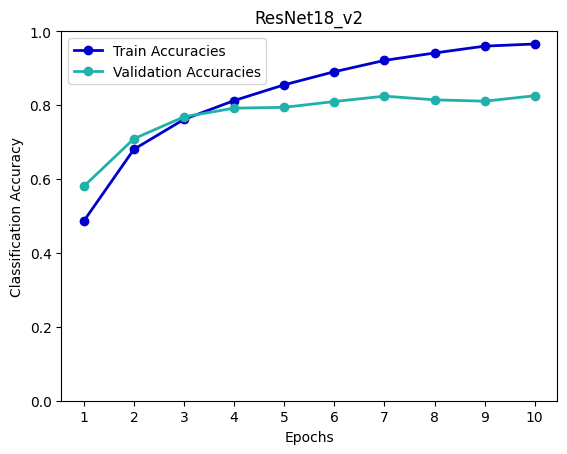

Training and testing Took: 29.3 minutes!
Training Accuracy %: 96.52
Validation Accuracy %: 82.52


In [46]:
# Initialise model instance
set_seed(seed)
model = ResNet18()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'ResNet18_v2'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

### Advanced Convolutional

#### Refinement for Baseline

In [47]:
# Define model
class Advanced_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5, padding = 2) #6 of 32-5+4+1=32 #added padding 2
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 2) #6 of 16-5+4+1 = 16 #added padding 2
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(16 * 8 * 8, 120) #8*8*6
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) #Apply convolution, batch normalization, ReLu and Max pooling
        x = self.dropout1(self.pool(F.relu(self.bn2(self.conv2(x))))) #Apply convolution, batch normalization, ReLu, Max pooling and dropnout

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1, Avg training loss 1.5101431958675384
Epoch 2, Avg training loss 1.245683353614807
Epoch 3, Avg training loss 1.1379725614070892
Epoch 4, Avg training loss 1.065450938796997
Epoch 5, Avg training loss 1.0150508026361464
Epoch 6, Avg training loss 0.9766820032835006
Epoch 7, Avg training loss 0.9414960217237472
Epoch 8, Avg training loss 0.9102083050251008
Epoch 9, Avg training loss 0.884851774430275
Epoch 10, Avg training loss 0.8592458065032959


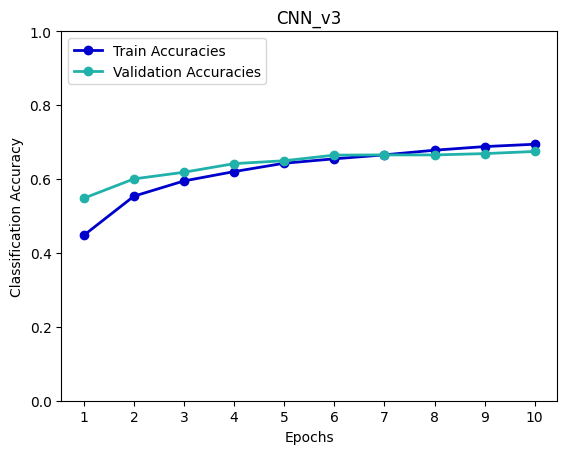

Training and testing Took: 2.7 minutes!
Training Accuracy %: 69.39
Validation Accuracy %: 67.44


In [48]:
# Initialise model instance
set_seed(seed)
model = Advanced_CNN()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'CNN_v3'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

### Advanced ResNet18

In [50]:
# Define the Resnet18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution layer modified for CIFAR-10 input size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.dropout1 = nn.Dropout(p=0.3) #Added dropnout layer

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout1(self.layer4(x)) #Added dropnout

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def Advanced_ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

Epoch 1, Avg training loss 1.408971108007431
Epoch 2, Avg training loss 0.918409635591507
Epoch 3, Avg training loss 0.6911535644650459
Epoch 4, Avg training loss 0.5524916442513466
Epoch 5, Avg training loss 0.4378104916572571
Epoch 6, Avg training loss 0.33630420557260515
Epoch 7, Avg training loss 0.24678535662293435
Epoch 8, Avg training loss 0.17410881391726435
Epoch 9, Avg training loss 0.13019164134562017
Epoch 10, Avg training loss 0.10223587556630373


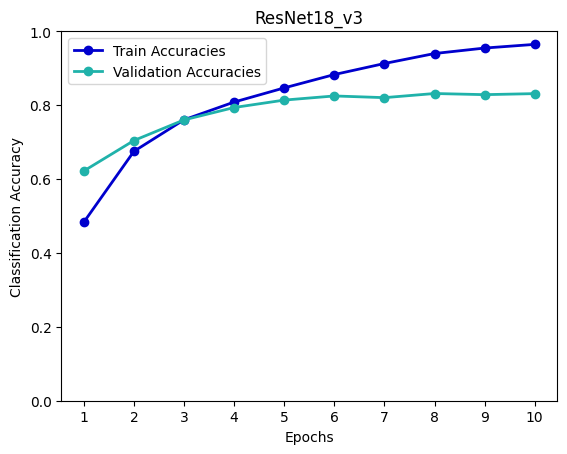

Training and testing Took: 29.61 minutes!
Training Accuracy %: 96.41
Validation Accuracy %: 83.09


In [51]:
# Initialise model instance
set_seed(seed)
model = Advanced_ResNet18()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training model
model_id = 'ResNet18_v3'
model_outputs = training_test_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader, model_id)

model_results = pd.concat([model_results, model_outputs],axis = 0)

In [52]:
#Save results for further analysis
model_results.to_csv('model_results.xlsx', index=False)

### Validation champion models in test sample

In [53]:
# Evaluate final models in test sample

# Model: CNN_v3
model_id = 'CNN_v3'
model_instance = Advanced_CNN()
load_and_test_model(model_id, model_instance, test_loader)

Accuracy% Test: 67.44


In [54]:
# Evaluate final models in test sample

# Model: ResNet18_v3
model_id = 'ResNet18_v3'
model_instance = Advanced_ResNet18()
load_and_test_model(model_id, model_instance, test_loader)

Accuracy% Test: 82.70


## Download final results

In [58]:
#Download models, outpus and plots
for model in model_results['model_id']:
    files.download(model+'.pth')
    files.download(f"accuracy_{model}.png")

files.download('model_results.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Document plots

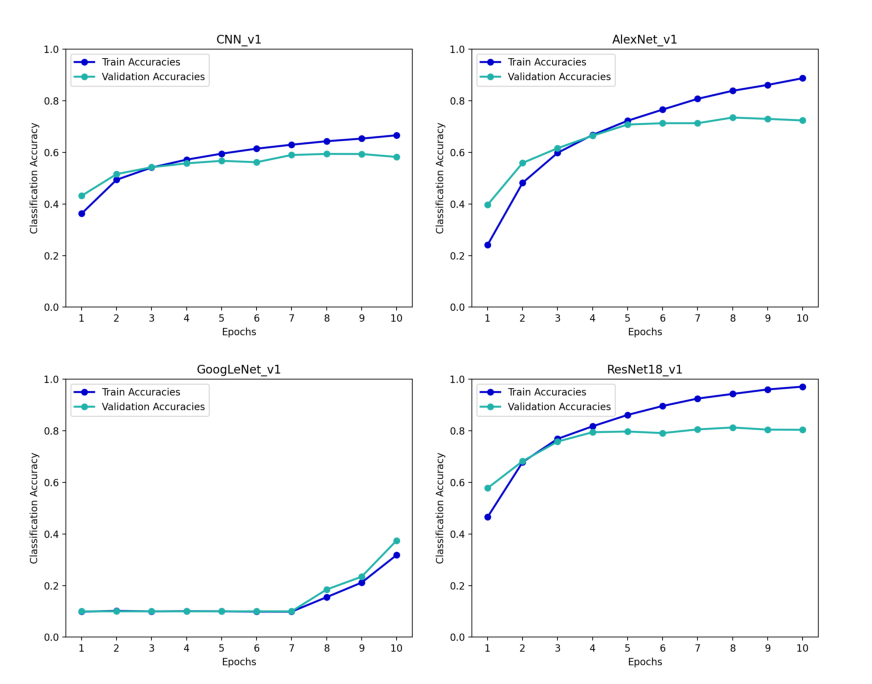

In [64]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the folder containing the images
folder_path = "Output Files"
images_names = ["accuracy_CNN_v1.png", "accuracy_AlexNet_v1.png", "accuracy_GoogLeNet_v1.png", "accuracy_ResNet18_v1.png"]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage1.png",dpi=200)
plt.show()

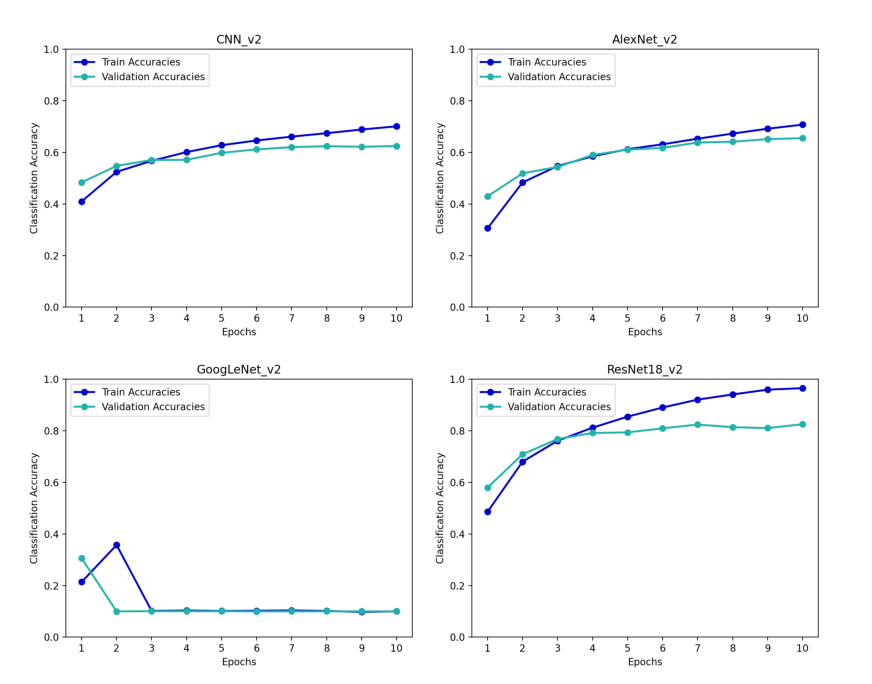

In [65]:
images_names = ["accuracy_CNN_v2.png", "accuracy_AlexNet_v2.png", "accuracy_GoogLeNet_v2.png", "accuracy_ResNet18_v2.png"]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage2.png",dpi=200)
plt.show()

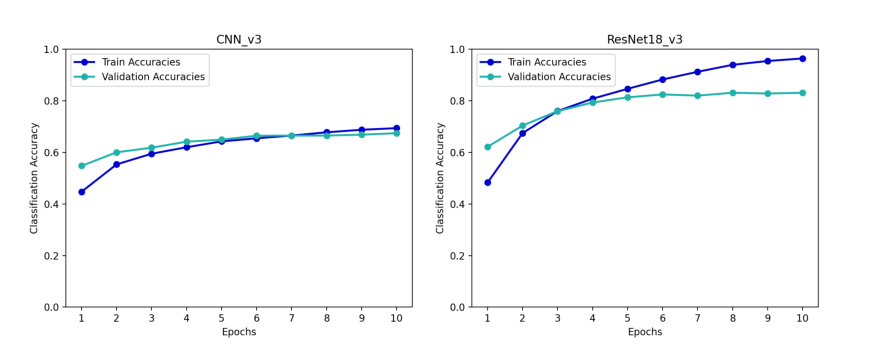

In [66]:
images_names = ["accuracy_CNN_v3.png", "accuracy_ResNet18_v3.png"]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create a 2x2 grid
fig, axes = plt.subplots(1, 2, figsize=(11, 9))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage3.png",dpi=200)
plt.show()